In [1]:
#| include: false

library(repr)
library(IRdisplay)
options(repr.plot.width=15, repr.plot.height=10)

In [2]:
#| include: false

library(here)
library(tidyverse)
library(lubridate)
library(estimatr)
library(fixest)
library(modelsummary)
library(kableExtra)
library(flextable)
library(officer)
library(RCTtoolbox)
library(patchwork)

options(
  knitr.table.format = "markdown",
  kableExtra.auto_format = FALSE,
  modelsummary_stars_note = FALSE,
  modelsummary_factory_default = "latex",
  modelsummary_factory_html = "kableExtra",
  modelsummary_factory_latex = "kableExtra",
  modelsummary_factory_word = "flextable"
)

In [3]:
#| include: false

root <- "D:/JMDPフィールド実験"

outcome_label <- list(
  reply = "Reply",
  positive = "Positive intention",
  negative = "Negative intention",
  test = "CT",
  candidate = "Candidate",
  consent = "Consent",
  donate = "Donation"
)

# Field Experiment
## Background: Coordination Process of JMDP


フィールド実験の介入のタイミングとデータの理解を促すために、骨髄バンクに登録したドナー候補者が幹細胞を提供するに至るまでの工程を概観しておく。
はじめに、あるドナー候補者のHLAが骨髄バンクに登録した患者のHLAと一致すると、骨髄バンクの事務局はその候補者に幹細胞提供を依頼する適合通知を送付する[^SNS]。
ドナー候補者は適合通知に対して提供の意向と問診表を記入して、返信する。

[^SNS]: 適合通知を送付したことを伝えるSMSメッセージも送付している。

提供を希望したドナー候補者はおよそ1カ月以内に確認検査を受ける。確認検査では、コーディネーターが提供方法（骨髄採取・末梢血幹細胞採取）を詳細に説明し、ドナー候補者とその家族の意向について調査する。
このとき、ドナー候補者は希望する採取方法を選べる。
また、調整医師が問診・診察・感染症の有無や血液型を調べるための一般血液検査を実施する。
この検査を通じて、ドナー候補者が、骨髄バンクが設定した基準を満たしているかどうかを調べる。

骨髄バンクに登録したドナーは同時に最大10人のドナー候補者とのコーディネーションを進められる。
患者の主治医は確認検査まで至った複数のドナー候補者の中から最も最適な候補者（第一候補者）を選ぶ。
重要な点であるが、ドナー候補者は自身とマッチした患者が何人のドナーとのコーディネーションを進めているかを知ることができない。
また、コーディネーターや調整医師もこの点を知らないので、ドナー候補者が他者からその情報を得ることもできない。

第一候補者となったドナーはコーディネーターと調整医師からの説明を再度受けて、最終的な意思決定をする（最終同意）。
このとき、ドナーの家族の代表者も採取に同意する必要がある。
また、最終同意後、ドナーは自分の意向を変えられない。
最終的な同意をした後、ドナーは約1週間の入院をして、術前検査と採取準備（貧血を防ぐための自己血採血）を受ける。
この後、ドナーは幹細胞を採取する処置を受ける。確認検査から採取までの期間はおよそ3～4カ月程度である。

## Experimental Design

![Intervention Messages](image/intervention.png){#fig-intervention}

我々は、骨髄バンクがドナー候補者に幹細胞提供を依頼する適合通知の内容に介入を施した。上図に介入の内容を示す。
介入前の適合通知はドナー候補者として選ばれたこと、7日以内に提供意思と問診表を記入して返信してほしいことを記載している。
また、適合通知と併せて同封した資料の一つは先の小節で述べた採取までの流れを示したハンドブックである。

我々はコーディネーションの促進を目的として、適合通知に行動科学の知見に基づく二種類のメッセージを追加した（@fig-intervention）[^pressure]。
確率メッセージは骨髄バンクに登録した患者とHLA型が一致するドナー登録者が少ないことを強調している。
これは同時に進行している他のドナー候補者の数に関する信念の過大評価を防ぎ、幹細胞提供の「ただ乗り」行動を抑制できる可能性がある。

[^pressure]: メッセージの作成の際、我々はドナー候補者に過度なプレッシャーを与えないように適切な配慮をしている。第一に、嘆願調のようなメッセージを避けている。第二に、メッセージの作成に際して、骨髄バンクが公開している情報のみを使用している。第三に、これまでと同様に移植リスクに関する説明をしている。

患者メッセージは骨髄バンクを通して移植を受けられる患者が半数しかいないことを強調している。
これは自分が協力しなくても患者は助かるだろうという認識を修正し、ドナー候補者の利他性を刺激していることを目的としている。
さらに、提供に至るまでの期間を短くすることの重要性を強調することで、適合通知への早い返信を促している。

二種類の介入メッセージの効果を推定するために、我々は四つの実験群を設ける。
実験群Aは介入メッセージのない適合通知を送る（コントロール群）。実験群BとCはそれぞれ確率メッセージと患者情報メッセージを送る。
さらに、情報過多による認知負荷の負の影響を検証するために、二つの介入メッセージを両方加えた適合通知を送付する実験群Dも設ける。

In [4]:
#| include: false

schedule <- read_csv(here(root, "RCT-schedule.csv"))

Rows: 24 Columns: 7


── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): treat
dbl  (4): year, month, week, RCTweek
date (2): start_date, end_date



ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [5]:
#| label: tbl-assignment
#| tbl-cap: "Assignment Schedule"
#| output: asis

schedule %>%
  mutate(
    my = paste0(month, "/", year - 2000),
    my = factor(
      my,
      levels = c("9/21", "10/21", "11/21", "12/21", "1/22", "2/22"),
      labels = c("Sep 21", "Oct 21", "Nov 21", "Dec 21", "Jan 22", "Feb 22")
    ),
    week = factor(week, levels = 1:4, labels = paste("Week", 1:4))
  ) %>%
  dplyr::select(week, my, treat) %>%
  pivot_wider(values_from = treat, names_from = my) %>%
  kable(
    align = 'lcccccc',
    booktabs = TRUE,
    linesep = ""
  ) %>%
  print()



|week   | Sep 21 | Oct 21 | Nov 21 | Dec 21 | Jan 22 | Feb 22 |
|:------|:------:|:------:|:------:|:------:|:------:|:------:|
|Week 1 |   B    |   C    |   C    |   D    |   B    |   A    |
|Week 2 |   D    |   B    |   A    |   A    |   C    |   B    |
|Week 3 |   A    |   D    |   B    |   C    |   D    |   C    |
|Week 4 |   C    |   A    |   D    |   B    |   A    |   D    |


我々は2021年9月から2022年2月にかけて骨髄バンクが適合通知を送付したドナー候補者11,154名をフィールド実験の対象とした。実験群の割り当ては骨髄バンク事務局の業務の無理のない範囲で週単位でクラスターランダム化した。このとき、週・月の固定効果を取り除けるように、実験群が週・月でバランスするように割り当てた。割り当てのスケジュールは @tbl-assignment にまとめている。

## Data and Empirical Strategy

In [6]:
#| include: false

rawdt <- read_csv(here(root, "shaped.csv"), locale = locale(encoding = "cp932"))

use <- rawdt %>%
  dplyr::filter(ongoing == 0) %>%
  mutate(
    treat = factor(treat, levels = LETTERS[1:4]),
    plan_two_methods = if_else(plan_method == "BM/PB", 1, 0)
  )

Rows: 11153 Columns: 39


── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr   (6): treat, prefecture, reasonBM, reasonPB, plan_method, method
dbl  (31): year, month, week, RCTweek, id, sentenceB, sentenceC, toka, male,...
date  (2): start_date, end_date



ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [7]:
#| include: false

lm_robust(
  ongoing ~ treat,
  data = rawdt,
  cluster = RCTweek,
  se_type = "stata"
) %>%
{
  f <- summary(.)$fstatistic[1]
  numdf <- summary(.)$fstatistic[2]
  dendf <- summary(.)$fstatistic[3]
  p <- pf(f, numdf, dendf, lower.tail = FALSE)

  sprintf("F-value = %1.3f; p-value = %1.3f", f, p)
}

[1] "F-value = 0.105; p-value = 0.956"

我々は2022年6月末に骨髄バンクが管理するコーディネーションデータの提供を受けた。観測単位はフィールド実験の対象であるドナー候補者である。個人属性として性別・年齢・過去のコーディネーション回数・居住地域（都道府県レベル）を記録している。コーディネーションの過程について、提供に至るまでの各工程（適合通知への返信・確認検査・第一候補者選定・最終同意・採取）に到達したかどうかを記録しており、これらをアウトカム変数として用いる。特に、適合通知の返信については、返信したかどうかに加えて、返信日数・提供意向についても記録している。コーディネーションが途中で中断した場合、その理由を三つのカテゴリー（患者理由・ドナーの健康以外の理由・ドナーの健康上の理由）で記録している。分析対象は国内在住でコーディネーションが完全に終了している11,049名とする[^exclude]。

[^exclude]: 海外に在住している人が1人いた。また、データ提供時点でコーディネーションが進行している人が104名いた。コーディネーションが進行している人の比率は実験群間でバランスしている（F-value, p-value = $0.956$）

追加的なデータとして、我々はJMDPがホームページ上で公開している施設リストを用いる。このデータは病院の住所に加えて、骨髄採取が可能かどうか、末梢血幹細胞採取が可能かどうかを含んでいる。我々はこのデータを都道府県レベルで集計して、10平方キロメートル当たりの病院の数を計算し、コーディネーションデータと都道府県をキーとして突合する。我々はこの変数をコーディネーションや提供の移動コストとみなす。

In [8]:
#| label: tbl-experiment-summary
#| tbl-cap: "Overview of Field Experiment"
#| output: asis

balance_test <- use %>%
  select(
    male,
    age,
    coordinate,
    hospital_per_area,
    PB_per_area,
    BM_per_area,
    treat,
    RCTweek
  ) %>%
  pivot_longer(male:BM_per_area, values_to = "value", names_to = "vars") %>%
  group_by(vars) %>%
  do(est = lm_robust(
    value ~ treat,
    clusters = RCTweek,
    se_type = "stata",
    data = .
  )) %>%
  summarize(
    vars = vars,
    f = summary(est)$fstatistic[1],
    numdf = summary(est)$fstatistic[2],
    dendf = summary(est)$fstatistic[3],
    "F-test, p-value" = pf(f, numdf, dendf, lower.tail = FALSE)
  )

size <- with(use, sprintf("%1d", table(treat))) %>%
  {
    tribble(
      ~terms, ~A, ~B, ~C, ~D, ~"F-test, p-value",
      "Standard notification", "X", "X", "X", "X", "",
      "Probability message", "", "X", "", "X", "",
      "Patients message", "", "", "X", "X", "",
      "N", .[1], .[2], .[3], .[4], ""
    )
  }

attr(size, "position") <- seq(nrow(size))

use %>%
  datasummary(
    (`Male (=1)` = male) +
    (`Age` = age) +
    (`Number of past coordinations` = coordinate) +
    (`Number of listed hospitals` = hospital_per_area) +
    (`Number of hospitals listed with PBSC collection` = PB_per_area) +
    (`Number of hospitals listed with BM collection` = BM_per_area) ~ mean * treat,
    data = .,
    add_rows = size,
    add_columns = balance_test[c(5, 1, 3, 4, 6, 2), 5],
    align = "lccccc",
  ) %>%
  kableExtra::kable_styling() %>%
  add_header_above(c(" " = 1, "Experimental Arms" = 4, " " = 1)) %>%
  group_rows("A. Interventions", 1, 3) %>%
  group_rows("B. Sample Size", 4, 4) %>%
  group_rows("C. Covariates, Balance Test", 5, 10) %>%
  print()

\begin{table}
\centering
\begin{tabular}[t]{lccccc}
\toprule
\multicolumn{1}{c}{ } & \multicolumn{4}{c}{Experimental Arms} & \multicolumn{1}{c}{ } \\
\cmidrule(l{3pt}r{3pt}){2-5}
  & A & B & C & D & F-test, p-value\\
\midrule
\addlinespace[0.3em]
\multicolumn{6}{l}{\textbf{A. Interventions}}\\
\hspace{1em}Standard notification & X & X & X & X & \\
\hspace{1em}Probability message &  & X &  & X & \\
\hspace{1em}Patients message &  &  & X & X & \\
\addlinespace[0.3em]
\multicolumn{6}{l}{\textbf{B. Sample Size}}\\
\hspace{1em}N & 2535 & 3053 & 2726 & 2735 & \\
\addlinespace[0.3em]
\multicolumn{6}{l}{\textbf{C. Covariates, Balance Test}}\\
\hspace{1em}Male (=1) & \num{0.62} & \num{0.63} & \num{0.63} & \num{0.61} & \num{0.36}\\
\hspace{1em}Age & \num{38.38} & \num{38.12} & \num{37.45} & \num{37.98} & \num{0.07}\\
\hspace{1em}Number of past coordinations & \num{1.61} & \num{1.59} & \num{1.62} & \num{1.56} & \num{0.45}\\
\hspace{1em}Number of listed hospitals & \num{0.48} & \num{0.49} & \num{0

@tbl-experiment-summary はフィールド実験を概観している。パネルAは各実験群の介入をまとめており、パネルBは各実験群のサンプルサイズを示している。パネルCは共変量のバランステストの結果を示しており、割り当てのランダム化が成功しているかどうかを検証している。ほとんどの共変量が群間でバランスしているので、実験群の割り当てはおおよそランダムである。ただし、実験群C・Dのドナー候補者は実験群A・Bのドナー候補者よりも若く、群間でアンバランスな可能性がある（F-test, p-value = $0.07$）。

ドナー候補者は実験群を選択できない、すなわち、実験群は外生的であるので、単純な二群比較は平均処置効果を識別できる。ただし、年齢および割り当ての週と月の数が実験群間で完全にバランスしていないので、単純な二群比較はバイアスを伴う可能性がある。そこで、二群比較に加えて、我々は$m$月の第$w$週に適合通知を受け取った個人$i$について以下の線形確率モデルを推定する、

\begin{equation}
  Y_{imw} =
  \beta_1 \cdot \text{B}_{mw} + \beta_2 \cdot \text{C}_{mw}
  + \beta_3 \cdot \text{D}_{mw}
  + X'_i \gamma + \lambda_m + \theta_w + u_{imw}
\end{equation}

ここで、$X_i$は個人属性ベクトル、$\lambda_m$と$\theta_w$はそれぞれ週・月のダミー変数である。
我々はランダム化のユニットである実験週レベルでクラスタした標準誤差を使用する。

# Results: Effects on Reply and Intentions

In [9]:
#| include: false

stock <- use %>%
  dplyr::filter(exg_stop_reply == 0) %>%
  rename(positive = intention) %>%
  mutate(
    negative = reply * (1 - positive),
    age_demean = age - mean(rawdt$age),
  ) %>%
  select(reply, positive, negative, everything()) %>%
  pivot_longer(reply:negative, names_to = "outcome") %>%
  mutate(outcome = factor(
    outcome,
    levels = unlist(names(outcome_label)[1:3]),
    labels = unlist(outcome_label[1:3])
  ))

はじめに、ドナー候補者の意向が最も現れる返信に対する効果を推定する。返信のアウトカム変数は提供意向に関わらず適合通知に返信したらならば1を取るダミー変数である。さらに、提供意向の変数を用いて、返信に対する効果を二つに分解する。第一に、正の意向を示して、適合通知に返信した効果である。アウトカム変数は適合通知に返信し、かつ提供の意向を示したならば1を取るダミー変数である。第二に、負の意向を示して、適合通知に返信した効果である。アウトカム変数は適合通知に返信し、かつ提供の意向を示さなければ1を取るダミー変数である。提供の意向に関する二つのアウトカム変数の和は必ず返信のアウトカム変数と一致するので、二つの意向に対する効果の和は必ず返信に対する効果となる。コントロール（実験群A）の返信率は$88.35$%である。正の意向を伴って返信した比率は$55.33$%である一方で、負の意向を伴って返信した比率は$33.03$%である。したがって、適合通知に返信したドナー候補者の$62.63$%が提供したいと考えている。

返信をする以前に患者側の都合でコーディネーションが中断してしまう可能性がある。このケースはドナー候補者の意向と無関係に生じるコーディネーションの中断なので、分析のサンプルから除外する。各実験群の$0.5$--$0.7$%をこのケースで除外しており、その比率は群間でバランスしている。

## Main Results

In [10]:
#| label: tbl-full-reply
#| tbl-cap: "Linear Probability Model of Replay and Intention"
#| output: asis

mod <- list(
  unctrl = value ~ treat,
  ctrl = value ~ treat + age_demean + I(age_demean^2) + male + coordinate +
    hospital_per_area + PB_per_area + BM_per_area +
    factor(prefecture) + factor(month) + factor(week)
)

est_stock <- stock %>%
  group_by(outcome) %>%
  nest() %>%
  mutate(
    fit1 = map(
      data,
      ~ lm_robust(
        mod$unctrl,
        data = .,
        cluster = RCTweek,
        se_type = "stata"
      )
    ),
    fit2 = map(
      data,
      ~ lm_robust(
        mod$ctrl,
        data = .,
        cluster = RCTweek,
        se_type = "stata"
      )
    )
  ) %>%
  pivot_longer(
    fit1:fit2,
    names_prefix = "fit",
    names_to = "model",
    values_to = "fit"
  )

ctrl_avg <- stock %>%
  dplyr::filter(treat == "A") %>%
  group_by(outcome) %>%
  summarize(mean = sprintf("%1.4f", mean(value)))

add_table <- tibble::tribble(
  ~term, ~"(1)", ~"(2)", ~"(3)", ~"(4)", ~"(5)", ~"(6)",
  "Control average", ctrl_avg$mean[1], ctrl_avg$mean[1],
  ctrl_avg$mean[2], ctrl_avg$mean[2],
  ctrl_avg$mean[3], ctrl_avg$mean[3],
  "Covariates", "", "X", "", "X", "", "X"
)

attr(add_table, "position") <- 9:12

est_stock %>%
  pull(fit) %>%
  setNames(paste0("(", seq_len(length(.)), ")")) %>%
  modelsummary(
    coef_map = c(
      "(Intercept)" = "Constant",
      "treatB" = "Treatment B",
      "treatC" = "Treatment C",
      "treatD" = "Treatment D"
    ),
    stars = c("***" = .01, "**" = .05, "*" = .1),
    fmt = 4,
    gof_omit = "R2|AIC|BIC|Log|Std|FE|se_type",
    add_rows = add_table,
  ) %>%
  kableExtra::kable_styling() %>%
  kableExtra::add_header_above(c(
    " " = 1, "Reply" = 2, "Positive" = 2, "Negative" = 2
  )) %>%
  kableExtra::add_header_above(c(
    " " = 3, "Intention" = 4
  )) %>%
  kableExtra::footnote(
    paste(
      "* p < 0.1, ** p < 0.05, *** p < 0.01.",
      "Standard errors clustered by experimental weeks",
      "are reported in parentheses.",
      "Covariates are gender, squared polynomial of (demeaned) age,",
      "number of past coordinations,",
      "number of hospitals per 10 square kilometers,",
      "number of hospitals with PBSC collection per 10 square kilometers,",
      "number of hospitals with BM collection per 10 square kilometers,",
      "prefecture dummies, month dummies, and week dummies."
    ),
    threeparttable = TRUE
  ) %>%
  print()

\begin{table}
\centering
\begin{threeparttable}
\begin{tabular}[t]{lcccccc}
\toprule
\multicolumn{3}{c}{ } & \multicolumn{4}{c}{Intention} \\
\cmidrule(l{3pt}r{3pt}){4-7}
\multicolumn{1}{c}{ } & \multicolumn{2}{c}{Reply} & \multicolumn{2}{c}{Positive} & \multicolumn{2}{c}{Negative} \\
\cmidrule(l{3pt}r{3pt}){2-3} \cmidrule(l{3pt}r{3pt}){4-5} \cmidrule(l{3pt}r{3pt}){6-7}
  & (1) & (2) & (3) & (4) & (5) & (6)\\
\midrule
Constant & \num{0.8835}*** & \num{0.9510}*** & \num{0.5533}*** & \num{0.6463}*** & \num{0.3303}*** & \num{0.3047}***\\
 & (\num{0.0065}) & (\num{0.0190}) & (\num{0.0125}) & (\num{0.0277}) & (\num{0.0089}) & (\num{0.0210})\\
Treatment B & \num{0.0105} & \num{0.0130}** & \num{0.0218} & \num{0.0203}* & \num{-0.0113} & \num{-0.0073}\\
 & (\num{0.0075}) & (\num{0.0061}) & (\num{0.0135}) & (\num{0.0123}) & (\num{0.0094}) & (\num{0.0075})\\
Treatment C & \num{-0.0057} & \num{0.0006} & \num{-0.0053} & \num{-0.0052} & \num{-0.0004} & \num{0.0057}\\
 & (\num{0.0081}) & (\num{0.0053

@tbl-full-reply は線形確率モデルの推定結果である。奇数列は実験群ダミーのみを説明変数として用いているのに対して、偶数列は個人属性や月・週の固定効果も制御している。列(1)は、確率メッセージを加えた適合通知を送付する実験群Bが返信率を$0.01$もしくは$1.2$%高めていることを示している。個人属性などをコントロールする（列(2)）と、効果のサイズは大きく変化しないが、統計的に5%水準で有意となる。この効果は正の意向を伴った返信の増加に由来している。列(3)と(5)では、実験群Bが正の意向を伴った返信率を$0.02$もしくは$3.94$%高めている一方で、負の意向を伴った返信率を$0.01$もしくは$3.42$%下げている。ただし、これらの統計的な有意性は弱い。また、実験群CとDは実験群Bよりも効果のサイズが小さく、統計的に非有意である。我々は頑健性の分析としてロジットモデルを推定した。その結果は効果の方向について上表と整合的であるが、統計的に非有意である。総合すると、我々の介入は全体的に返信に大きな影響を与えていない。

3 coefficients  not defined because the design matrix is rank deficient




3 coefficients  not defined because the design matrix is rank deficient




3 coefficients  not defined because the design matrix is rank deficient




3 coefficients  not defined because the design matrix is rank deficient




3 coefficients  not defined because the design matrix is rank deficient




3 coefficients  not defined because the design matrix is rank deficient




3 coefficients  not defined because the design matrix is rank deficient




3 coefficients  not defined because the design matrix is rank deficient




3 coefficients  not defined because the design matrix is rank deficient




3 coefficients  not defined because the design matrix is rank deficient




3 coefficients  not defined because the design matrix is rank deficient




3 coefficients  not defined because the design matrix is rank deficient




Adding missing grouping variables: `outcome`


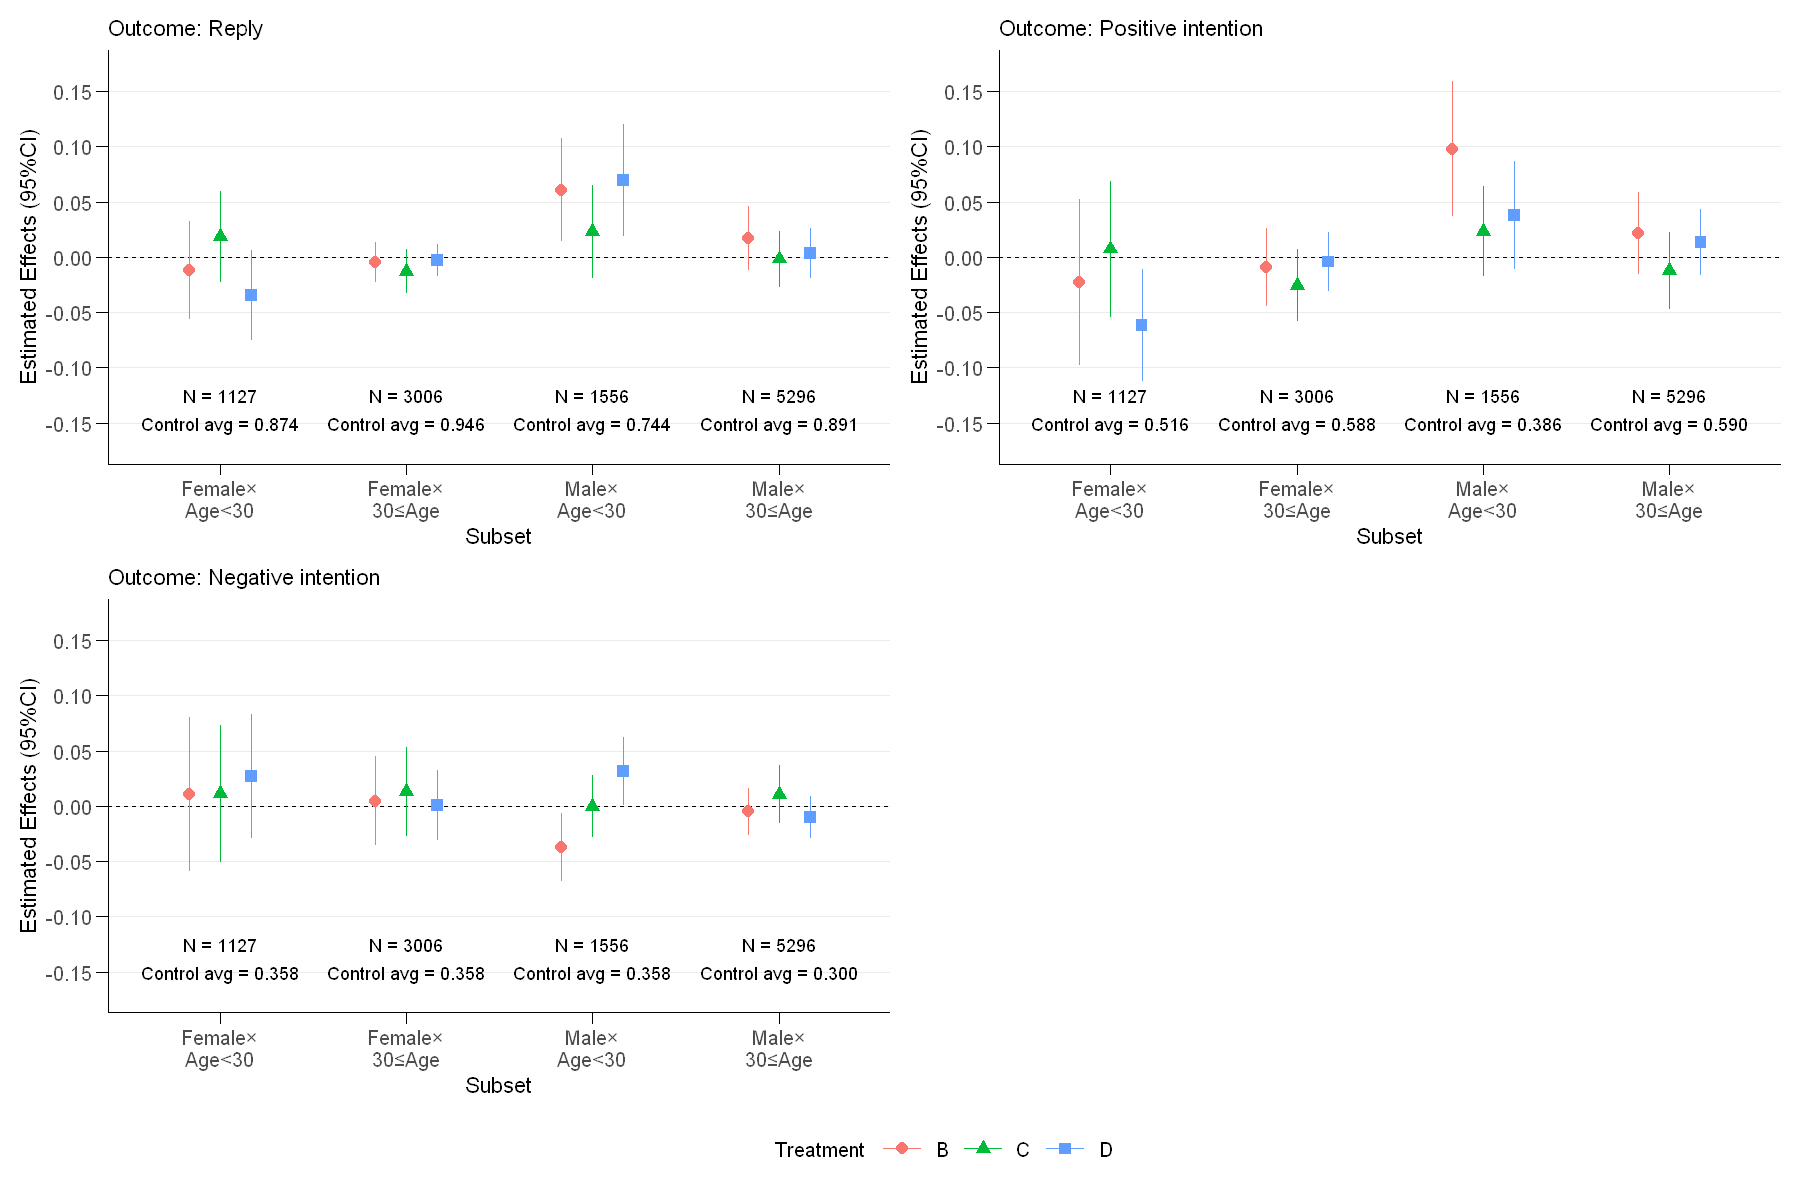

In [11]:
#| label: fig-subsample-reply
#| fig-cap: 'Effect on Reply and Intentions by Gender and Age Group. Note: These plots show the average effect (and associated 95% confidential interval) on each outcome by gender and age group. We cluster standard errors by experimental weeks. We control number of past coordinations, number of hospitals per 10 square kilometers, number of hospitals with PBSC collection per 10 square kilometers, number of hospitals with BM collection per 10 square kilometers, prefecture dummies, month dummies, and week dummies.'

est_stock_sub <- stock %>%
  mutate(age_less30 = if_else(age < 30, 1, 0)) %>%
  group_by(outcome, male, age_less30) %>%
  nest() %>%
  mutate(est = map(data, ~ lm_robust(
    update(mod$ctrl, . ~ . - male - age_demean),
    cluster = RCTweek,
    se_type = "stata",
    data = .x
  ))) %>%
  mutate(
    fit = map(est, tidy),
    fit = map(fit, ~ subset(.x, str_detect(term, "treat"))),
    fit = map(fit, ~ dplyr::select(.x, -outcome)),
    N = map_chr(est, ~ paste("N =", nobs(.x))),
    mean = map_dbl(data, ~ with(subset(., treat == "A"), mean(value))),
    mean = sprintf("Control avg = %1.3f", mean)
  ) %>%
  select(-data, -est) %>%
  unnest(cols = fit) %>%
  mutate(
    pos = paste0(male, age_less30),
    pos = factor(
      pos,
      levels = c("01", "00", "11", "10"),
      labels = c(
        "Female\u00d7\nAge<30",
        "Female\u00d7\n30\u2264Age",
        "Male\u00d7\nAge<30",
        "Male\u00d7\n30\u2264Age"
      )
    ),
    term = str_replace(term, "treat", ""),
    term = factor(term, LETTERS[2:4])
  )

text <- est_stock_sub %>%
  select(male, age_less30, pos, N, mean) %>%
  distinct()

plot_list <- unique(est_stock_sub$outcome) %>%
  purrr::map(function(x) {
    subset(est_stock_sub, outcome == x) %>%
      ggplot(aes(x = pos, y = estimate)) +
      geom_hline(aes(yintercept = 0), linetype = 2) +
      geom_point(
        aes(color = term, shape = term),
        size = 3, position = position_dodge(0.5)
      ) +
      geom_errorbar(
        aes(ymin = conf.low, ymax = conf.high, color = term),
        position = position_dodge(0.5),
        width = 0
      ) +
      geom_text(
        aes(y = -0.125, label = N),
        data = subset(text, outcome == x),
        color = "black"
      ) +
      geom_text(
        aes(y = -0.15, label = mean),
        data = subset(text, outcome == x),
        color = "black"
      ) +
      scale_y_continuous(
        breaks = seq(-0.2, 0.2, by = 0.05), limits = c(-0.17, 0.17)
      ) +
      labs(
        title = paste("Outcome:", x),
        x = "Subset",
        y = "Estimated Effects (95%CI)",
        color = "Treatment", shape = "Treatment"
      ) +
      simplegg()
  })

wrap_plots(plot_list, ncol = 2) +
  plot_layout(guides = "collect") &
  theme(legend.position = "bottom")

次に、メッセージの効果の異質性を検証するために、我々は性別と年齢層（30歳未満かどうか）でサンプルを4分割して、各サブセットでメッセージの効果を推定している。 @fig-subsample-reply はその係数プロットである。その結果、確率メッセージを加えた実験群BとDは30歳未満の男性の返信率を$0.06$もしくは$8.06$%高めている（ベースラインの返信率は$74.4$%）。とくに、確率メッセージだけを加えた実験群Bの効果は正の意向を伴う返信率の増加に起因している。このグループで、実験群Bは正の意向を伴う返信率を$0.1$もしくは$25.91$%高めている（ベースラインの比率は$38.6$%）一方で、負の意向を伴う返信率を$0.03$もしくは$8.38$%下げている（ベースラインの比率は$35.8$%）。これらは統計的に有意な効果である。対して、他の性年代のグループ（とくに、30歳以上の男女）では、介入メッセージが返信や意向に大きな影響を与えていない。ただし、30歳未満の女性で、実験群Dが正の意向を伴う返信率を$0.05$もしくは$9.69$%下げている。したがって、他のドナー候補者が少ないというメッセージは若年男性の提供意向を高め、適合通知への返信を促している。若年男性ドナーは移植成績が良いにも関わらず、提供意向が他の性年代よりも明らかに低いことを考慮すると、確率メッセージは移植コーディネーションの効率性を改善しているといえる

## Response Speed to Notification

In [12]:
#| include: false

flow <- stock %>%
  mutate(
    days_reply = if_else(is.na(days_reply), 10000, days_reply),
    days4 = if_else(days_reply <= 4, value, 0),
    days7 = if_else(days_reply <= 7, value, 0),
    days10 = if_else(days_reply <= 10, value, 0),
    days14 = if_else(days_reply <= 14, value, 0),
    days21 = if_else(days_reply <= 21, value, 0),
    days28 = if_else(days_reply <= 28, value, 0)
  ) %>%
  select(-value) %>%
  pivot_longer(days4:days28, names_to = "within", names_prefix = "days") %>%
  mutate(within = as.numeric(within))

患者メッセージはドナー候補者の利他性を刺激しており、特に、適合通知に早く返信することで患者の移植率に貢献できることを強調している。そこで、確率メッセージも含めた二つの介入メッセージが適合通知への返信スピードにどのような影響を与えたかを検証する。そこで、我々は$d$日以内に返信する確率$\text{Pr}(D_{imw} \le d)$を線形確率モデルで推定する。このとき、アウトカム変数は$d$日以内に返信したならば1を取るようなダミー変数である。ただし、$d$の値を十分に大きくすると、$\text{Pr}(D_{imw} \le d)$に対する効果は前小節で示した返信に対する効果と一致する。

また、前小節と同様に、$\text{Pr}(D_{imw} \le d)$に対する効果を提供意向の観点から二つの効果に分解する。正の意向については、提供意向があり、かつ$d$日以内に返信したならば1を取るようなダミー変数である。負の意向については、提供意向がなく、かつ$d$日以内に返信したならば1を取るようなダミー変数である。

3 coefficients  not defined because the design matrix is rank deficient




3 coefficients  not defined because the design matrix is rank deficient




3 coefficients  not defined because the design matrix is rank deficient




3 coefficients  not defined because the design matrix is rank deficient




3 coefficients  not defined because the design matrix is rank deficient




3 coefficients  not defined because the design matrix is rank deficient




3 coefficients  not defined because the design matrix is rank deficient




3 coefficients  not defined because the design matrix is rank deficient




3 coefficients  not defined because the design matrix is rank deficient




3 coefficients  not defined because the design matrix is rank deficient




3 coefficients  not defined because the design matrix is rank deficient




3 coefficients  not defined because the design matrix is rank deficient




3 coefficients  not defined because the design matrix is rank deficient




3 coefficients  not defined because the design matrix is rank deficient




3 coefficients  not defined because the design matrix is rank deficient




3 coefficients  not defined because the design matrix is rank deficient




3 coefficients  not defined because the design matrix is rank deficient




3 coefficients  not defined because the design matrix is rank deficient




`summarise()` has grouped output by 'outcome'. You can override using the
`.groups` argument.


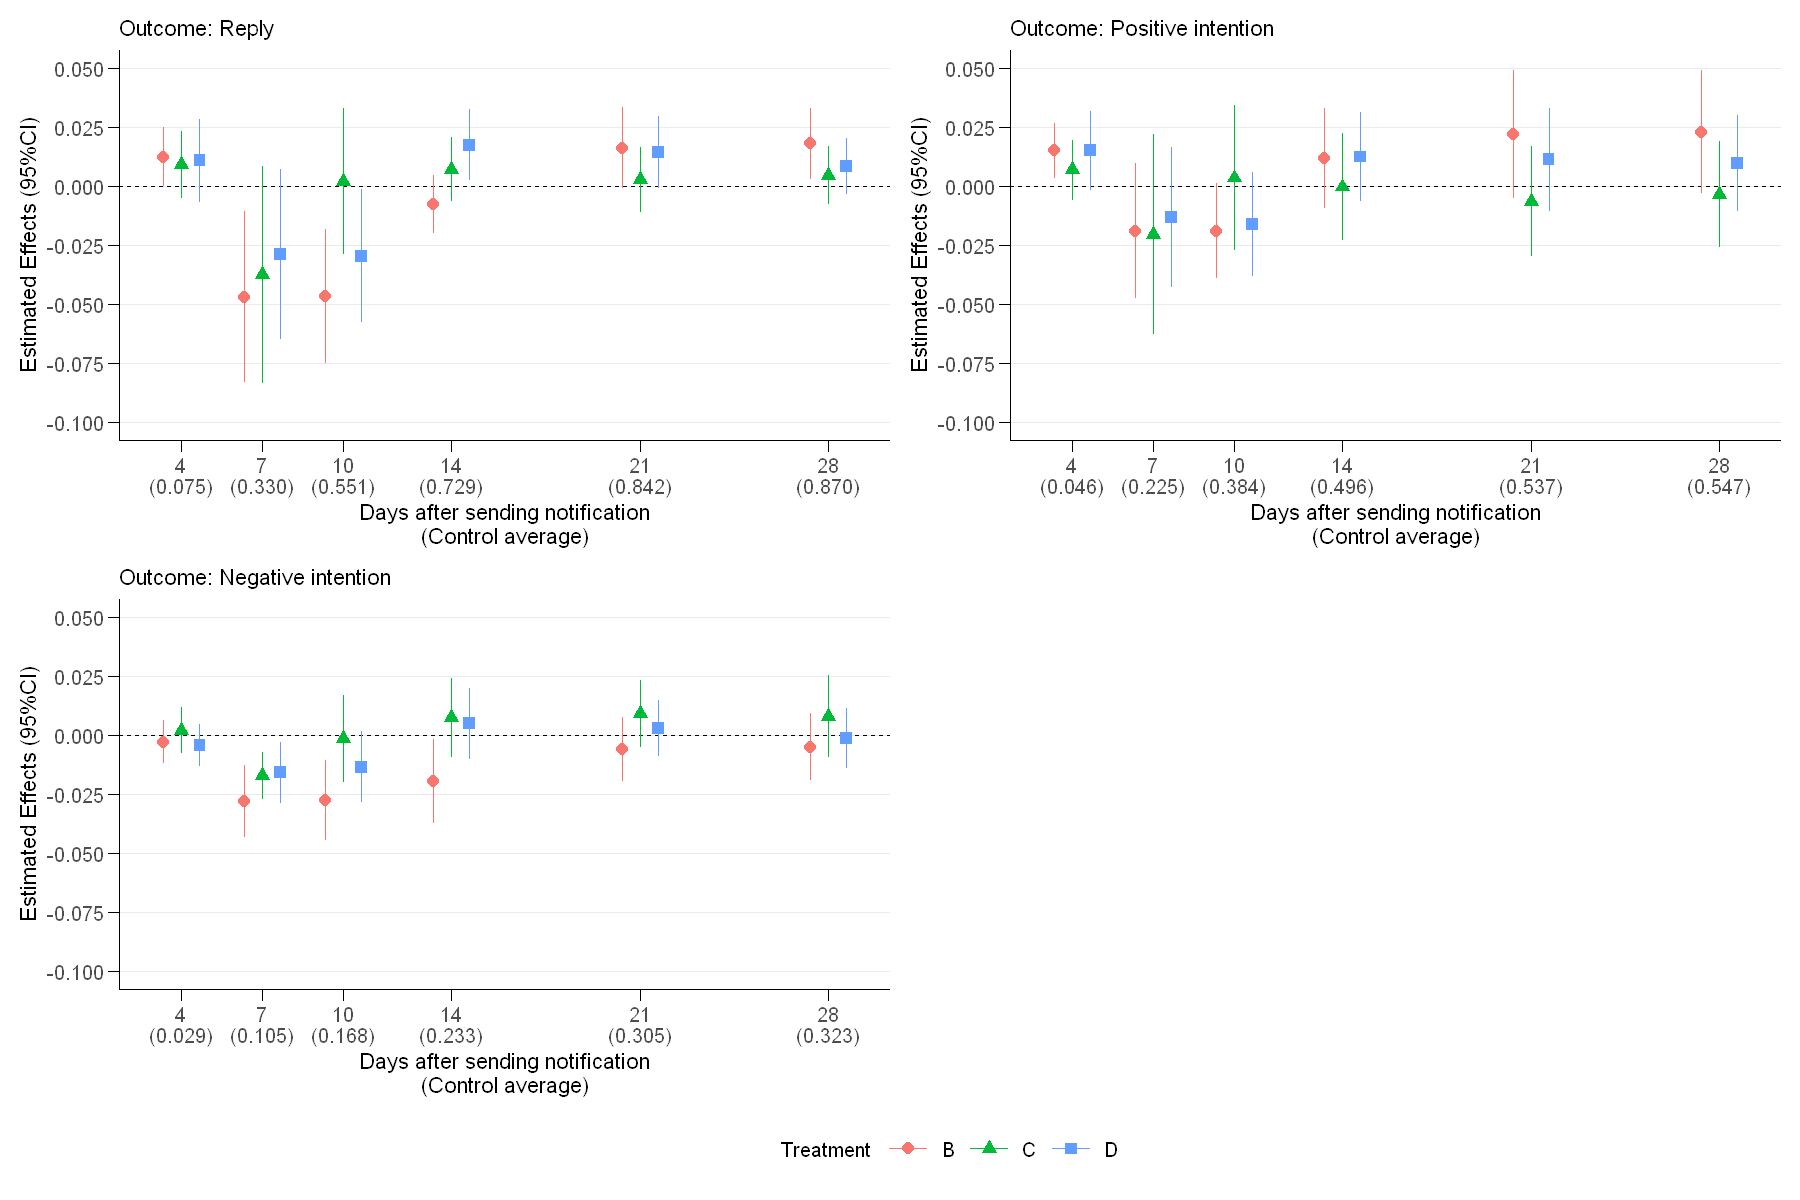

In [13]:
#| label: fig-full-speed
#| fig-cap: "Effect on Reply within Specific Days after Sending Notification. Notes: These plots show the average effect (and associated 95% confidential interval) on each outcome."

est_flow <- flow %>%
  group_by(outcome, within) %>%
  nest() %>%
  mutate(fit = map(data, ~ lm_robust(
    mod$ctrl,
    cluster = RCTweek,
    se_type = "stata",
    data = .x
  ))) %>%
  mutate(
    tidy = map(fit, tidy),
    tidy = map(tidy, ~ subset(.x, str_detect(term, "treat"))),
    tidy = map(tidy, ~ dplyr::select(.x, -outcome))
  ) %>%
  dplyr::select(-data, -fit) %>%
  unnest(cols = tidy) %>%
  mutate(
    term = str_replace(term, "treat", ""),
    term = factor(term, LETTERS[2:4])
  )

ctrl_avg <- flow %>%
  dplyr::filter(treat == "A") %>%
  group_by(outcome, within) %>%
  summarize(mean = mean(value)) %>%
  mutate(mean = sprintf("%1d\n(%1.3f)", within, mean))

plot_list <- unique(est_flow$outcome) %>%
  purrr::map(function(x) {
    subset(est_flow, outcome == x) %>%
      ggplot(aes(x = within, y = estimate, color = term, shape = term)) +
      geom_hline(aes(yintercept = 0), linetype = 2) +
      geom_point(size = 3, position = position_dodge(2)) +
      geom_errorbar(
        aes(ymin = conf.low, ymax = conf.high),
        position = position_dodge(2),
        width = 0
      ) +
      scale_x_continuous(
        breaks = subset(ctrl_avg, outcome == x)$within,
        labels = subset(ctrl_avg, outcome == x)$mean
      ) +
      scale_y_continuous(
        breaks = seq(-0.2, 0.2, by = 0.025), limits = c(-0.1, 0.05)
      ) +
      labs(
        title = paste("Outcome:", x),
        x = "Days after sending notification\n(Control average)",
        y = "Estimated Effects (95%CI)",
        color = "Treatment", shape = "Treatment"
      ) +
      simplegg()
  })

wrap_plots(plot_list, ncol = 2) +
  plot_layout(guides = "collect") &
  theme(legend.position = "bottom")

In [14]:
#| include: false

est_flow_sub <- flow %>%
  mutate(age_less30 = if_else(age < 30, 1, 0)) %>%
  dplyr::filter(age_less30 == 1) %>%
  group_by(outcome, within, male) %>%
  nest() %>%
  mutate(
    fit = map(data, ~ lm_robust(
      update(mod$ctrl, . ~ . - male - age_demean),
      cluster = RCTweek,
      se_type = "stata",
      data = .x
    )),
    avg = map_chr(data, ~ sprintf(
      "%1d\n(%1.3f)", within, with(subset(.x, treat == "A"), mean(value))
    ))
  ) %>%
  mutate(
    tidy = map(fit, tidy),
    tidy = map(tidy, ~ subset(.x, str_detect(term, "treat"))),
    tidy = map(tidy, ~ dplyr::select(.x, -outcome))
  ) %>%
  dplyr::select(-data, -fit) %>%
  unnest(cols = tidy) %>%
  mutate(
    term = str_replace(term, "treat", ""),
    term = factor(term, LETTERS[2:4])
  )

est_flow_sub

3 coefficients  not defined because the design matrix is rank deficient




3 coefficients  not defined because the design matrix is rank deficient




3 coefficients  not defined because the design matrix is rank deficient




3 coefficients  not defined because the design matrix is rank deficient




3 coefficients  not defined because the design matrix is rank deficient




3 coefficients  not defined because the design matrix is rank deficient




3 coefficients  not defined because the design matrix is rank deficient




3 coefficients  not defined because the design matrix is rank deficient




3 coefficients  not defined because the design matrix is rank deficient




3 coefficients  not defined because the design matrix is rank deficient




3 coefficients  not defined because the design matrix is rank deficient




3 coefficients  not defined because the design matrix is rank deficient




3 coefficients  not defined because the design matrix is rank deficient




3 coefficients  not defined because the design matrix is rank deficient




3 coefficients  not defined because the design matrix is rank deficient




3 coefficients  not defined because the design matrix is rank deficient




3 coefficients  not defined because the design matrix is rank deficient




3 coefficients  not defined because the design matrix is rank deficient




3 coefficients  not defined because the design matrix is rank deficient




3 coefficients  not defined because the design matrix is rank deficient




3 coefficients  not defined because the design matrix is rank deficient




3 coefficients  not defined because the design matrix is rank deficient




3 coefficients  not defined because the design matrix is rank deficient




3 coefficients  not defined because the design matrix is rank deficient




3 coefficients  not defined because the design matrix is rank deficient




3 coefficients  not defined because the design matrix is rank deficient




3 coefficients  not defined because the design matrix is rank deficient




3 coefficients  not defined because the design matrix is rank deficient




3 coefficients  not defined because the design matrix is rank deficient




3 coefficients  not defined because the design matrix is rank deficient




3 coefficients  not defined because the design matrix is rank deficient




3 coefficients  not defined because the design matrix is rank deficient




3 coefficients  not defined because the design matrix is rank deficient




3 coefficients  not defined because the design matrix is rank deficient




3 coefficients  not defined because the design matrix is rank deficient




3 coefficients  not defined because the design matrix is rank deficient




male,outcome,within,avg,term,estimate,std.error,statistic,p.value,conf.low,conf.high,df
<dbl>,<fct>,<dbl>,<chr>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,Reply,4,4 (0.049),B,-0.006328884,0.009918907,-0.6380626,5.297351e-01,-0.026847706,0.0141899381,23
0,Reply,4,4 (0.049),C,0.061846769,0.009458265,6.5389128,1.133466e-06,0.042280858,0.0814126808,23
0,Reply,4,4 (0.049),D,0.038252858,0.011056710,3.4596962,2.126848e-03,0.015380311,0.0611254051,23
0,Reply,7,7 (0.317),B,-0.139458482,0.027537860,-5.0642454,3.978058e-05,-0.196424886,-0.0824920774,23
0,Reply,7,7 (0.317),C,-0.032841460,0.036112901,-0.9094108,3.725652e-01,-0.107546688,0.0418637666,23
0,Reply,7,7 (0.317),D,-0.033710309,0.037525892,-0.8983213,3.783226e-01,-0.111338530,0.0439179124,23
0,Reply,10,10 (0.496),B,-0.082339482,0.029961241,-2.7482000,1.145112e-02,-0.144319031,-0.0203599332,23
0,Reply,10,10 (0.496),C,0.060706352,0.024242283,2.5041516,1.981181e-02,0.010557370,0.1108553346,23
0,Reply,10,10 (0.496),D,-0.010907611,0.031041341,-0.3513898,7.284946e-01,-0.075121517,0.0533062940,23


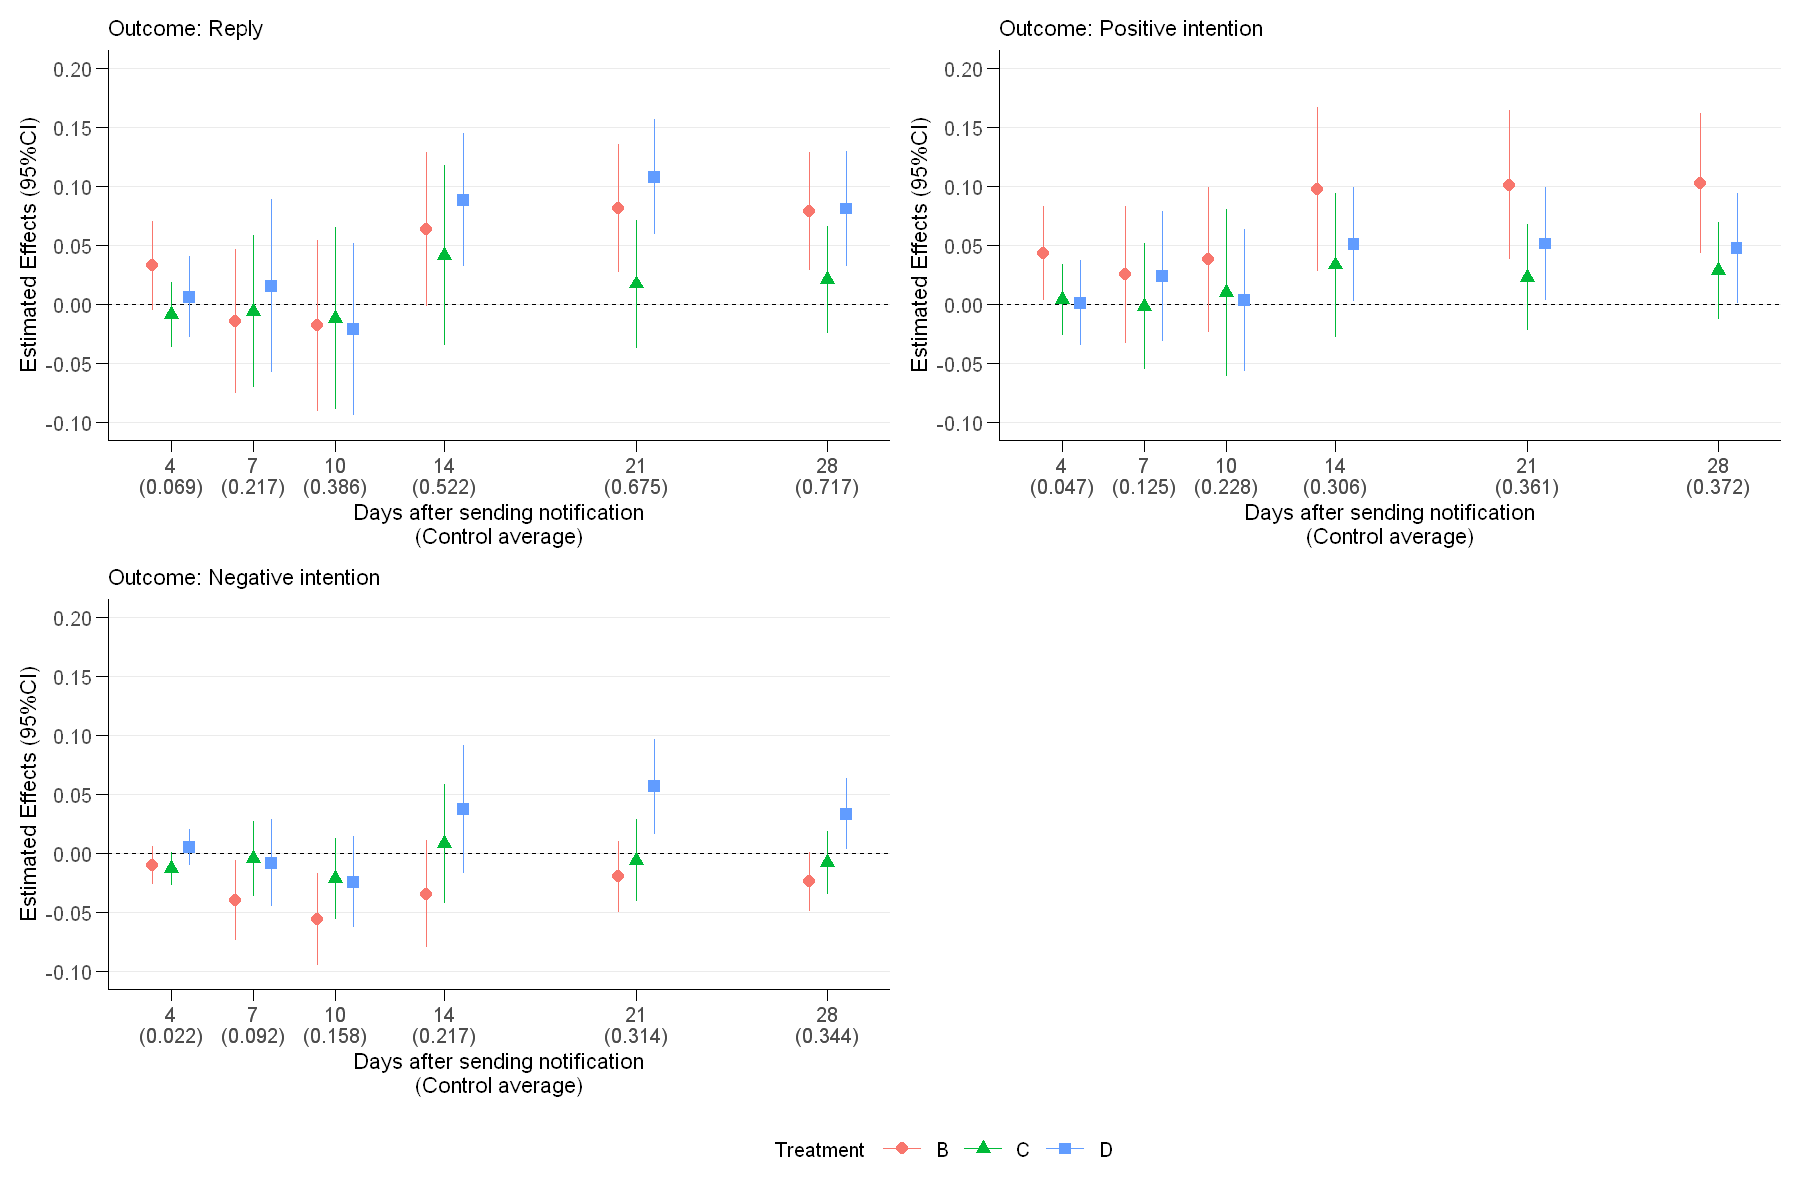

In [15]:
#| label: fig-young-male-speed
#| fig-cap: "Effect on Reply within Specific Days after Sending Notification among Males Less than 30. Notes: These plots show the average effect (and associated 95% confidential interval) on each outcome."

plot_list_male <- unique(est_flow_sub$outcome) %>%
  purrr::map(function(x) {
    subset(est_flow_sub, male == 1 & outcome == x) %>%
      ggplot(aes(x = within, y = estimate, color = term, shape = term)) +
      geom_hline(aes(yintercept = 0), linetype = 2) +
      geom_point(size = 3, position = position_dodge(2)) +
      geom_errorbar(
        aes(ymin = conf.low, ymax = conf.high),
        position = position_dodge(2),
        width = 0
      ) +
      scale_x_continuous(
        breaks = subset(est_flow_sub, male == 1 & outcome == x)$within,
        labels = subset(est_flow_sub, male == 1 & outcome == x)$avg
      ) +
      scale_y_continuous(
        breaks = seq(-0.2, 0.2, by = 0.05), limits = c(-0.1, 0.2)
      ) +
      labs(
        title = paste("Outcome:", x),
        x = "Days after sending notification\n(Control average)",
        y = "Estimated Effects (95%CI)",
        color = "Treatment", shape = "Treatment"
      ) +
      simplegg()
  })

wrap_plots(plot_list_male, ncol = 2) +
  plot_layout(guides = "collect") &
  theme(legend.position = "bottom")

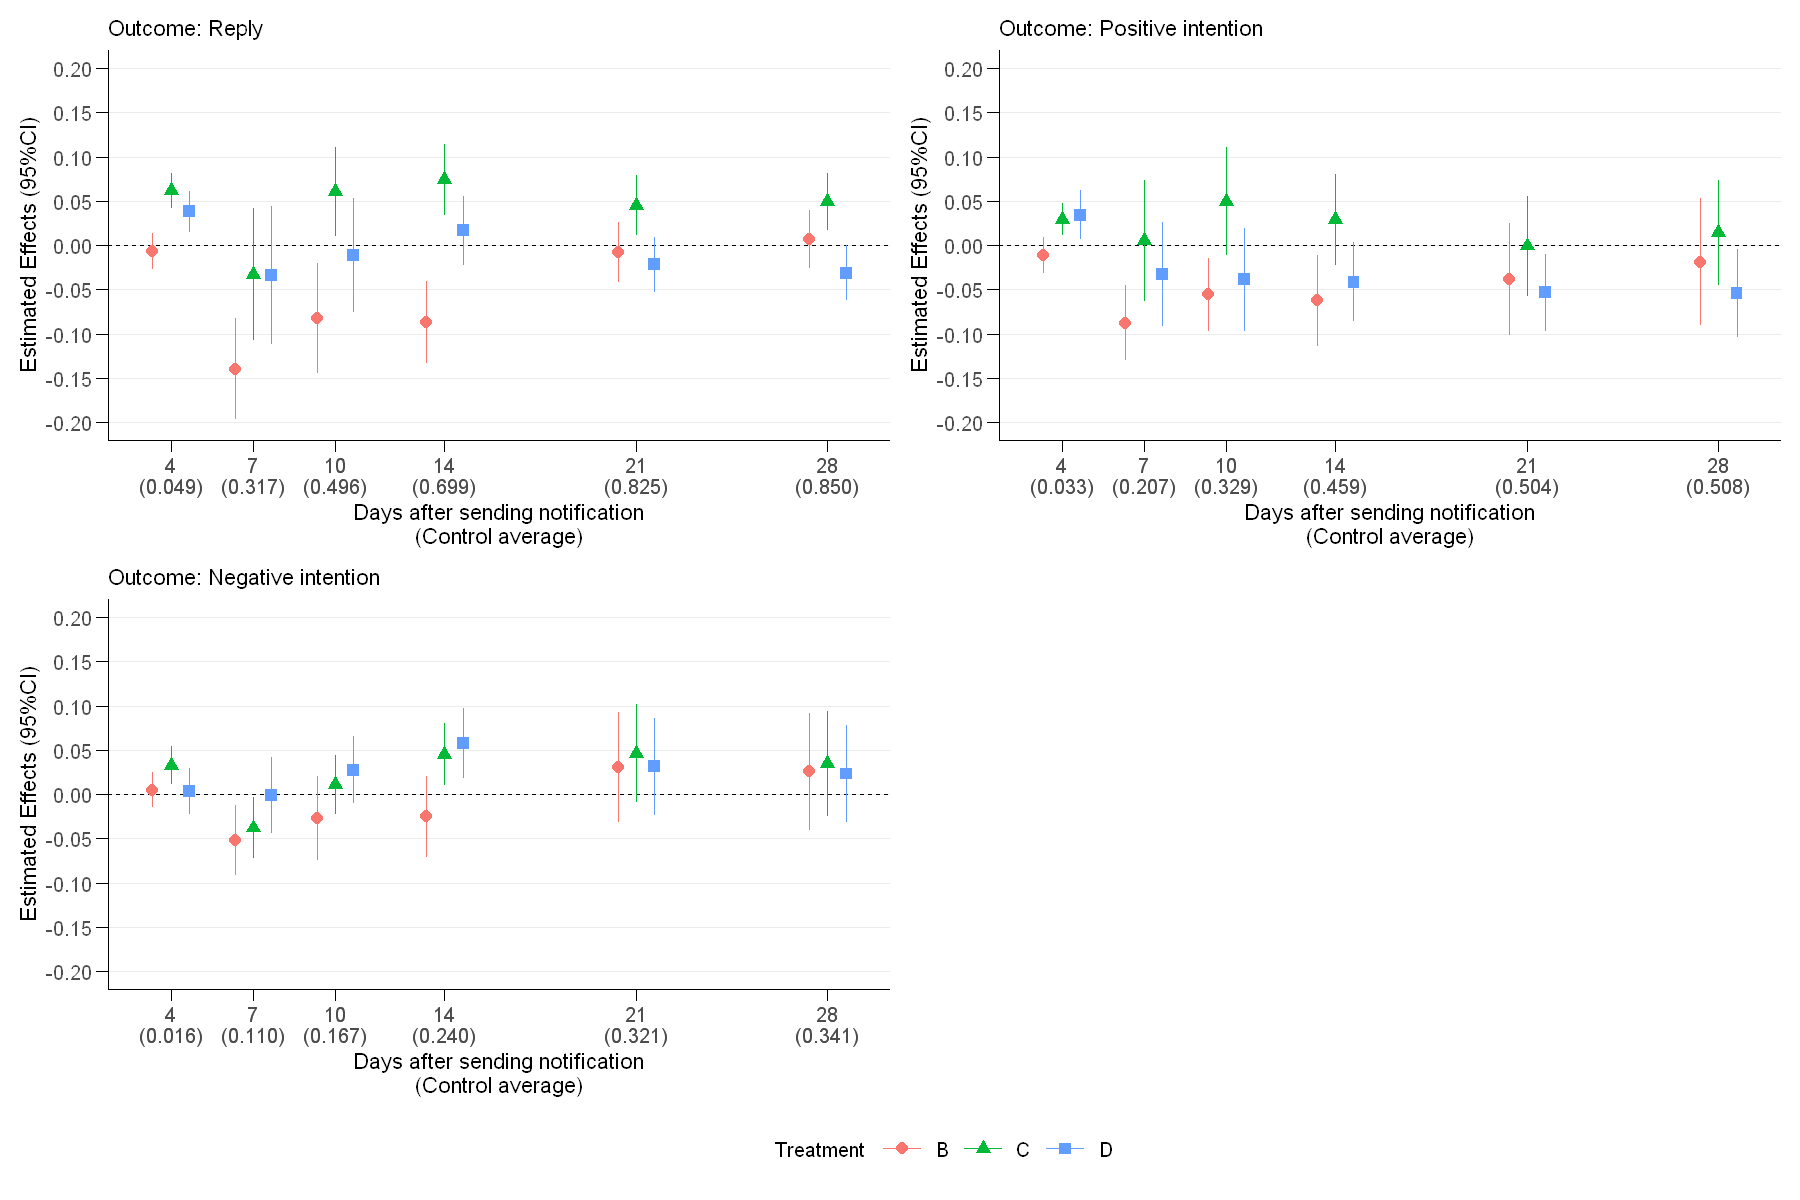

In [16]:
#| label: fig-young-female-speed
#| fig-cap: "Effect on Reply within Specific Days after Sending Notification among Females Less than 30. Notes: These plots show the average effect (and associated 95% confidential interval) on each outcome."

plot_list_female <- unique(est_flow_sub$outcome) %>%
  purrr::map(function(x) {
    subset(est_flow_sub, male == 0 & outcome == x) %>%
      ggplot(aes(x = within, y = estimate, color = term, shape = term)) +
      geom_hline(aes(yintercept = 0), linetype = 2) +
      geom_point(size = 3, position = position_dodge(2)) +
      geom_errorbar(
        aes(ymin = conf.low, ymax = conf.high),
        position = position_dodge(2),
        width = 0
      ) +
      scale_x_continuous(
        breaks = subset(est_flow_sub, male == 0 & outcome == x)$within,
        labels = subset(est_flow_sub, male == 0 & outcome == x)$avg
      ) +
      scale_y_continuous(
        breaks = seq(-0.2, 0.2, by = 0.05), limits = c(-0.2, 0.2)
      ) +
      labs(
        title = paste("Outcome:", x),
        x = "Days after sending notification\n(Control average)",
        y = "Estimated Effects (95%CI)",
        color = "Treatment", shape = "Treatment"
      ) +
      simplegg()
  })

wrap_plots(plot_list_female, ncol = 2) +
  plot_layout(guides = "collect") &
  theme(legend.position = "bottom")

# Results: Effects on Coordination Process

In [17]:
#| include: false

exclude <- use %>%
  select(id, starts_with("exg_stop")) %>%
  pivot_longer(
    -id,
    names_to = "outcome", values_to = "exclude",
    names_prefix = "exg_stop_"
  )

coordination <- use %>%
  select(test, candidate, consent, donate, everything()) %>%
  pivot_longer(test:donate, names_to = "outcome") %>%
  dplyr::left_join(exclude, by = c("id", "outcome")) %>%
  mutate(
    age_demean = age - mean(rawdt$age),
    outcome = factor(
      outcome,
      levels = unlist(names(outcome_label)[4:7]),
      labels = unlist(outcome_label[4:7])
    )
  )

In [18]:
#| label: tbl-full-coordination
#| tbl-cap: "Linear Probability Model of Coordination Process."
#| output: asis

est_coordination <- coordination %>%
  group_by(outcome) %>%
  nest() %>%
  mutate(
    fit1 = map(
      data,
      ~ lm_robust(
        mod$unctrl,
        data = subset(., exclude == 0),
        cluster = RCTweek,
        se_type = "stata"
      )
    ),
    fit2 = map(
      data,
      ~ lm_robust(
        mod$ctrl,
        data = subset(., exclude == 0),
        cluster = RCTweek,
        se_type = "stata"
      )
    ),
    avg = map_chr(
      data,
      ~ with(
        subset(., exclude == 0 & treat == "A"),
        sprintf("%.4f", mean(value))
      )
    )
  ) %>%
  pivot_longer(
    fit1:fit2,
    names_prefix = "fit",
    names_to = "model",
    values_to = "fit"
  ) %>%
  select(- data)

add_table <- c("Control average", est_coordination$avg) %>%
  rbind(c("Covariates", "", "Y", "", "Y", "", "Y", "", "Y")) %>%
  data.frame()

attr(add_table, "position") <- c(9, 10)

est_coordination %>%
  pull(fit) %>%
  modelsummary(
    coef_map = c(
      "(Intercept)" = "Constant",
      "treatB" = "Treatment B",
      "treatC" = "Treatment C",
      "treatD" = "Treatment D"
    ),
    stars = c("***" = .01, "**" = .05, "*" = .1),
    fmt = 4,
    gof_omit = "R2|AIC|BIC|Log|Std|FE|se_type",
    add_rows = add_table
  ) %>%
  kableExtra::kable_styling() %>%
  kableExtra::add_header_above(c(
    " " = 1, "CT" = 2, "Candidate" = 2, "Consent" = 2, "Donation" = 2
  )) %>%
  kableExtra::footnote(
    paste(
      "* p < 0.1, ** p < 0.05, *** p < 0.01.",
      "Standard errors clustered by experimental weeks",
      "are reported in parentheses.",
      "Covariates are gender, squared polynomial of (demeaned) age,",
      "number of past coordinations,",
      "number of hospitals per 10 square kilometers,",
      "number of hospitals with PBSC collection per 10 square kilometers,",
      "number of hospitals with BM collection per 10 square kilometers,",
      "prefecture dummies, month dummies, and week dummies."
    ),
    threeparttable = TRUE
  ) %>%
  print()
  # as.character() %>%
  # display_html()

\begin{table}
\centering
\begin{threeparttable}
\begin{tabular}[t]{lcccccccc}
\toprule
\multicolumn{1}{c}{ } & \multicolumn{2}{c}{CT} & \multicolumn{2}{c}{Candidate} & \multicolumn{2}{c}{Consent} & \multicolumn{2}{c}{Donation} \\
\cmidrule(l{3pt}r{3pt}){2-3} \cmidrule(l{3pt}r{3pt}){4-5} \cmidrule(l{3pt}r{3pt}){6-7} \cmidrule(l{3pt}r{3pt}){8-9}
  & (1) & (2) & (3) & (4) & (5) & (6) & (7) & (8)\\
\midrule
Constant & \num{0.2350}*** & \num{0.1531}*** & \num{0.0779}*** & \num{0.0472}** & \num{0.0687}*** & \num{0.0318} & \num{0.0574}*** & \num{0.0272}*\\
 & (\num{0.0115}) & (\num{0.0295}) & (\num{0.0065}) & (\num{0.0224}) & (\num{0.0062}) & (\num{0.0197}) & (\num{0.0052}) & (\num{0.0164})\\
Treatment B & \num{0.0325}** & \num{0.0351}*** & \num{0.0051} & \num{0.0049} & \num{0.0059} & \num{0.0051} & \num{0.0040} & \num{0.0032}\\
 & (\num{0.0141}) & (\num{0.0076}) & (\num{0.0076}) & (\num{0.0049}) & (\num{0.0074}) & (\num{0.0042}) & (\num{0.0060}) & (\num{0.0044})\\
Treatment C & \num{0.0146} 

In [19]:
#| include: false

est_coordination_sub <- coordination %>%
  mutate(age_less30 = if_else(age < 30, 1, 0)) %>%
  group_by(outcome, male, age_less30) %>%
  nest() %>%
  mutate(est = map(data, ~ lm_robust(
    update(mod$ctrl, . ~ . - male - age_demean),
    cluster = RCTweek,
    se_type = "stata",
    data = subset(.x, exclude == 0)
  ))) %>%
  mutate(
    fit = map(est, tidy),
    fit = map(fit, ~ subset(.x, str_detect(term, "treat"))),
    fit = map(fit, ~ dplyr::select(.x, -outcome)),
    N = map_chr(est, ~ paste("N =", nobs(.x))),
    mean = map_dbl(data, ~ with(subset(., exclude == 0 & treat == "A"), mean(value))),
    mean = sprintf("Control avg = %1.3f", mean)
  ) %>%
  select(-data, -est) %>%
  unnest(cols = fit) %>%
  mutate(
    pos = paste0(male, age_less30),
    pos = factor(
      pos,
      levels = c("01", "00", "11", "10"),
      labels = c(
        "Female\u00d7\nAge<30",
        "Female\u00d7\n30\u2264Age",
        "Male\u00d7\nAge<30",
        "Male\u00d7\n30\u2264Age"
      )
    ),
    term = str_replace(term, "treat", ""),
    term = factor(term, LETTERS[2:4])
  )

3 coefficients  not defined because the design matrix is rank deficient




3 coefficients  not defined because the design matrix is rank deficient




3 coefficients  not defined because the design matrix is rank deficient




3 coefficients  not defined because the design matrix is rank deficient




3 coefficients  not defined because the design matrix is rank deficient




3 coefficients  not defined because the design matrix is rank deficient




3 coefficients  not defined because the design matrix is rank deficient




3 coefficients  not defined because the design matrix is rank deficient




3 coefficients  not defined because the design matrix is rank deficient




3 coefficients  not defined because the design matrix is rank deficient




3 coefficients  not defined because the design matrix is rank deficient




3 coefficients  not defined because the design matrix is rank deficient




3 coefficients  not defined because the design matrix is rank deficient




3 coefficients  not defined because the design matrix is rank deficient




3 coefficients  not defined because the design matrix is rank deficient




3 coefficients  not defined because the design matrix is rank deficient




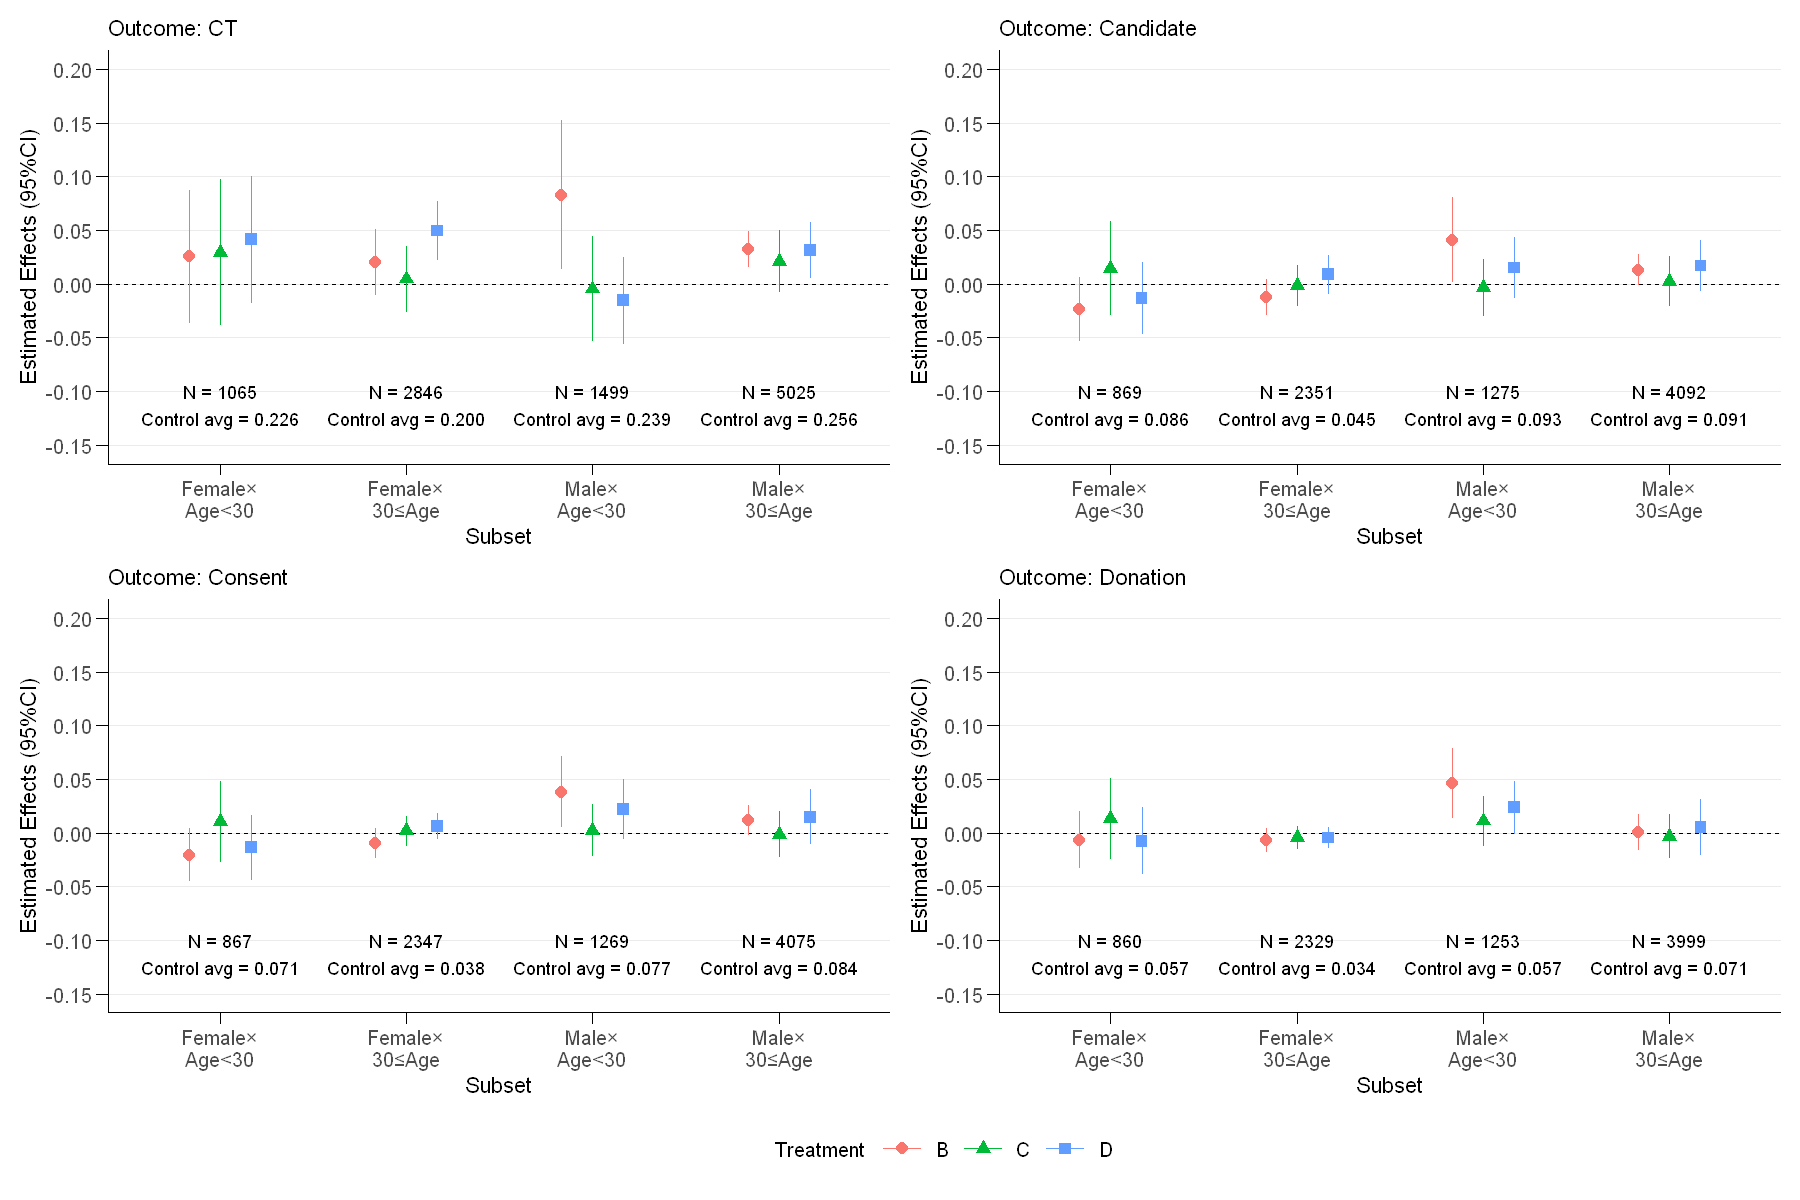

In [20]:
#| label: fig-subsample-coordination
#| fig-cap: "Effect on Coordination by Gender and Age Group. Note: These plots show the average effect (and associated 95% confidential interval) on each outcome by gender and age group. We cluster standard errors by experimental weeks. We control number of past coordinations, number of hospitals per 10 square kilometers, number of hospitals with PBSC collection per 10 square kilometers, number of hospitals with BM collection per 10 square kilometers, prefecture dummies, month dummies, and week dummies."

text <- est_coordination_sub %>%
  ungroup() %>%
  select(male, age_less30, pos, N, mean, outcome) %>%
  distinct()

plot_list <- unique(est_coordination_sub$outcome) %>%
  purrr::map(function(x) {
    subset(est_coordination_sub, outcome == x) %>%
      ggplot(aes(x = pos, y = estimate)) +
      geom_hline(aes(yintercept = 0), linetype = 2) +
      geom_point(
        aes(color = term, shape = term),
        size = 3, position = position_dodge(0.5)
      ) +
      geom_errorbar(
        aes(ymin = conf.low, ymax = conf.high, color = term),
        position = position_dodge(0.5),
        width = 0
      ) +
      geom_text(
        aes(y = -0.1, label = N),
        data = subset(text, outcome == x),
        color = "black"
      ) +
      geom_text(
        aes(y = -0.125, label = mean),
        data = subset(text, outcome == x),
        color = "black"
      ) +
      scale_y_continuous(
        breaks = seq(-0.2, 0.2, by = 0.05), limits = c(-0.15, 0.2)
      ) +
      labs(
        title = paste("Outcome:", x),
        x = "Subset",
        y = "Estimated Effects (95%CI)",
        color = "Treatment", shape = "Treatment"
      ) +
      simplegg()
  })

wrap_plots(plot_list, ncol = 2) +
  plot_layout(guides = "collect") &
  theme(legend.position = "bottom")